**결측치 채우는 방법**

DT

In [7]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import missingno as msno
import seaborn as sns 
import os


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

In [8]:
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("fivethirtyeight")
# 이미지가 레이아웃 안으로 들어오도록 함
mpl.rcParams.update({"figure.constrained_layout.use": True})

In [9]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
[fm.FontProperties(fname=font).get_name() for font in font_list if 'D2C' in font]
plt.rc('font', family='D2Coding')
mpl.rcParams['axes.unicode_minus'] = False

In [10]:
DATASET_DIR = '/home/doeun/code/AI/ESTSOFT2024/workspace/dataset/'
load_dir = 'america_big_cities_health_inventory'
file_name = 'BigCitiesHealth.csv'
RSLT_DIR = '/home/doeun/code/AI/ESTSOFT2024/workspace/1.project1_structured/BCHI/processed/'
pvtb_dir = RSLT_DIR + 'pvtb/'

## FUNCTIONS

- preprocess

In [11]:
def count_key_opt(data:pd.DataFrame,key,opt):
    rslt = dict()
    labels = data[key].unique()
    form = data[opt].value_counts().sort_values(ascending=False)
    form.iloc[:] = 0

    for feat in labels:
        cond = data[key]==feat
        val = form.copy()
        temp = data.loc[cond,opt].value_counts()
        val.loc[temp.index] = temp
        rslt[feat] = val

    return pd.DataFrame(rslt).T

In [12]:
import functools

def cond_check_dict(data=pd.DataFrame,val_dict=dict):
    cond_list=[
        data[col] == val
        for col, val in val_dict.items()
    ]
    return functools.reduce(lambda x,y: x & y, cond_list)

- plot

In [13]:
import re

def choose_split_point(word_len,space,ths):
    # 윗 줄에 space 만큼 공백이 있고, 한 줄의 길이가 ths로 제한 되어있을 때
    # 어떤 지점에서 단어를 끊어줄지 정하기
    # |-------ths-------|
    # |-space-|---------|-space-|------| : word
    #         |-------ths-------|
    print(word_len,space,ths)
    if word_len < ths + space :
        if abs(word_len/2 -ths) <= abs(word_len/2-space) :
            return word_len-ths
        else :
            return word_len - space if word_len < 2 * space else space
    else :
        return ths if word_len - (ths + space) < 0.3 * ths else space

def minimize_seq_idx_np(domain:np.array,func):
    vfunc = np.vectorize(func)
    temp = np.argsort(vfunc(domain))
    return temp[0]

def modify_strlen_ths(last,new,ths=16):
    front = len(last)
    space = ths - (1+front)
    if len(new) < space :
        rslt = [last + ' ' + new]
    else :
        if len(new) < ths:
            rslt = [last, new]
        else:
            cut = choose_split_point(len(new),space-1,ths-1)
            new_h, new_e = new[:cut]+'-', new[cut:]
            if cut < ths-1 :
                rslt = modify_strlen_ths(last+' '+new_h,new_e)
            else :
                rslt = [last] + modify_strlen_ths(new_h,new_e) 
    return rslt

def str_cutter(sentnc, ths = 16):
    words= sentnc.split(' ')
    rslt, pnt = [''], 0
    while pnt < len(words):
        last = '' if len(rslt)==0 else rslt[-1]
        next_ele = modify_strlen_ths(last,words[pnt],ths)
        rslt = rslt[:-1] + next_ele
        pnt += 1
    return '\n'.join(rslt)[1:]
#알고리즘 때문에 맨 앞에 빈칸 하나 들어가게 되는 이슈 있음

print(str_cutter('Racial Segregation Indices | Racial Segregation, White and Hispanic', 13))



Racial
Segregation
Indices |
Racial
Segregation,
White and
Hispanic


In [14]:
def choose_plot_grid(n:int,r_max=8,c_max=17,res_ths=2):
    #ver2
    r_min = np.ceil(n/c_max)
    sppt = np.arange(r_min,r_max+1) #need error process
    col_nums = np.ceil(n/sppt)
    res = col_nums * sppt -n
    min_idx = np.where((res==np.min(res)) | (res <= res_ths))[0]
    row_cand, col_cand = sppt[min_idx], col_nums[min_idx]
    if len(min_idx) > 1 :
        res = np.abs(row_cand-col_cand)
        i = np.where(res==np.min(res))[0][0]
    else : i = 0
    return int(row_cand[i]), int(col_cand[i])


def pair_plot_feat_hue(fig,axes,data:dict,pair_plot,axis_share=False,hue_label_dict=None, **kwargs):
    #ver2
    if (fig is None) or (axes is None) :
        num_r, num_c = choose_plot_grid(len(data))
        fig, axes = plt.subplots(num_r,num_c,figsize=(21,17),sharex=axis_share,sharey=axis_share)
    for n,key in enumerate(data.keys()):
        ax = axes.flatten()[n]
        plt.setp(ax.get_xticklabels(),ha = 'left',rotation = 90)
        if n >= len(data) : continue
        pair_plot(x=data[key][0], y = data[key][1],ax =ax, **kwargs)
        feat_name = str(key) 
        if hue_label_dict: color = 'b' if hue_label_dict[feat_name] else 'k'
        else : color = 'k'
        ax.set_xlabel(str_cutter(feat_name,20),loc='left',fontsize = 8.3,color=color)
    return fig,axes

## pvtb_city_encoded_ver1 로 변경 , DT모델적용


In [18]:
# CSV 파일 경로
file_name = 'pvtb_city_encoded_ver1.csv'
file_path = os.path.join(RSLT_DIR,pvtb_dir,file_name)

# CSV 파일 읽기
pvtb_entire_1 = pd.read_csv(file_path, index_col=0)

# 데이터프레임의 컬럼 출력
print(pvtb_entire_1.columns.tolist())
pvtb_entire_1.head()

pvtb_entire = pvtb_entire_1[list(pvtb_entire_1.columns)[1:]]

['geo_label_city', 'encoded_strata_race_label', 'encoded_strata_sex_label', 'encoded_geo_strata_region', 'encoded_geo_strata_poverty', 'encoded_geo_strata_Population', 'encoded_geo_strata_PopDensity', 'encoded_geo_strata_Segregation', 'date_label', 'Active Transportation | Riding Bike to Work', 'Active Transportation | Walking to Work', 'Air Pollution | Hazardous Air Quality', 'Air Pollution | Poor Air Quality', 'Birth Control | Teen Birth Control', 'Births | Low Birthweight', 'Births | Prenatal Care', 'Births | Preterm Births', 'Births | Teen Births', 'Cancer | All Cancer Deaths', 'Cancer | Breast Cancer Deaths', 'Cancer | Colorectal Cancer Deaths', 'Cancer | Lung Cancer Deaths', 'Cancer | Prostate Cancer Deaths', 'Cardiovascular Disease | Cardiovascular Disease Deaths', 'Cardiovascular Disease | Heart Disease Deaths', 'Cardiovascular Disease | High Blood Pressure', 'Crime Incidents | Homicides', 'Crime Incidents | Violent Crime', 'Deaths | Deaths from All Causes', 'Deaths | Gun Death

In [29]:
pvtb_entire.head()

,encoded_strata_race_label,encoded_strata_sex_label,encoded_geo_strata_region,encoded_geo_strata_poverty,encoded_geo_strata_Population,encoded_geo_strata_PopDensity,encoded_geo_strata_Segregation,date_label,Active Transportation | Riding Bike to Work,Active Transportation | Walking to Work,...,Substance Use | Adult Smoking,Substance Use | Drug Overdose Deaths,Substance Use | Opioid Overdose Deaths,Substance Use | Teen Alcohol,Substance Use | Teen Marijuana,Substance Use | Teen Smoking,Transportation | Drives Alone to Work,Transportation | Lack of Car,Transportation | Longer Driving Commute Time,Transportation | Public Transportation Use
0,0,0,2,1,0,0,0,2010,1.458997,2.506039,...,14.1,14.814379,5.316296,NaN,NaN,NaN,71.701852,7.104797,NaN,4.673879
1,0,1,2,1,0,0,0,2010,NaN,NaN,...,NaN,12.110401,4.224056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,2,1,0,0,0,2010,NaN,NaN,...,NaN,17.451652,6.417004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,2,1,0,0,0,2010,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,2,1,0,0,0,2010,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# 원핫인코딩 수행
pvtb_encoded = pd.get_dummies(pvtb_entire, columns=['encoded_strata_race_label', 'encoded_strata_sex_label','encoded_geo_strata_region'])


In [32]:
# 원핫인코딩 후 생성된 컬럼 확인
print(pvtb_encoded.columns)

Index(['encoded_geo_strata_poverty', 'encoded_geo_strata_Population',
       'encoded_geo_strata_PopDensity', 'encoded_geo_strata_Segregation',
       'date_label', 'Active Transportation | Riding Bike to Work',
       'Active Transportation | Walking to Work',
       'Air Pollution | Hazardous Air Quality',
       'Air Pollution | Poor Air Quality',
       'Birth Control | Teen Birth Control',
       ...
       'encoded_strata_race_label_3', 'encoded_strata_race_label_4',
       'encoded_strata_race_label_5', 'encoded_strata_sex_label_0',
       'encoded_strata_sex_label_1', 'encoded_strata_sex_label_2',
       'encoded_geo_strata_region_0', 'encoded_geo_strata_region_1',
       'encoded_geo_strata_region_2', 'encoded_geo_strata_region_3'],
      dtype='object', length=136)


In [37]:
# 특징 변수와 타겟 변수 분리

strata_one_hot_cols= ['encoded_strata_race_label_0', 'encoded_strata_race_label_1',
       'encoded_strata_race_label_2', 'encoded_strata_race_label_3',
       'encoded_strata_race_label_4', 'encoded_strata_race_label_5',
       'encoded_strata_sex_label_0', 'encoded_strata_sex_label_1',
       'encoded_strata_sex_label_2', 'encoded_geo_strata_region_0', 'encoded_geo_strata_region_1',
       'encoded_geo_strata_region_2', 'encoded_geo_strata_region_3']
strata_ordinal_cols = ['encoded_geo_strata_poverty', 'encoded_geo_strata_Population',
       'encoded_geo_strata_PopDensity', 'encoded_geo_strata_Segregation',
       'date_label']

set(pvtb_encoded.columns).intersection(set(strata_ordinal_cols))

{'date_label',
 'encoded_geo_strata_PopDensity',
 'encoded_geo_strata_Population',
 'encoded_geo_strata_Segregation',
 'encoded_geo_strata_poverty'}

In [67]:
target_col = ['Deaths | Premature Death']

df_data = pvtb_encoded[strata_one_hot_cols+strata_ordinal_cols+target_col]

df_nonan = df_data.dropna()

df_nonan

,encoded_strata_race_label_0,encoded_strata_race_label_1,encoded_strata_race_label_2,encoded_strata_race_label_3,encoded_strata_race_label_4,encoded_strata_race_label_5,encoded_strata_sex_label_0,encoded_strata_sex_label_1,encoded_strata_sex_label_2,encoded_geo_strata_region_0,encoded_geo_strata_region_1,encoded_geo_strata_region_2,encoded_geo_strata_region_3,encoded_geo_strata_poverty,encoded_geo_strata_Population,encoded_geo_strata_PopDensity,encoded_geo_strata_Segregation,date_label,Deaths | Premature Death
0,True,False,False,False,False,False,True,False,False,False,False,True,False,1,0,0,0,2010,5094.792265
1,True,False,False,False,False,False,False,True,False,False,False,True,False,1,0,0,0,2010,3807.898474
2,True,False,False,False,False,False,False,False,True,False,False,True,False,1,0,0,0,2010,6377.256790
3,False,False,False,False,True,False,True,False,False,False,False,True,False,1,0,0,0,2010,2579.797021
4,False,False,False,False,True,False,False,True,False,False,False,True,False,1,0,0,0,2010,2025.151915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7274,False,False,False,True,False,False,False,True,False,False,False,True,False,1,0,1,1,2022,2692.047582
7275,False,False,False,True,False,False,False,False,True,False,False,True,False,1,0,1,1,2022,6300.589535
7277,False,True,False,False,False,False,True,False,False,False,False,True,False,1,0,1,1,2022,2231.116039
7278,False,True,False,False,False,False,False,True,False,False,False,True,False,1,0,1,1,2022,1609.792900


In [68]:
X = df_nonan[strata_one_hot_cols+strata_ordinal_cols]
y = df_nonan[target_col]

In [110]:
# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=801)

# 결정 트리 모델 생성 및 학습
dt_model = DecisionTreeRegressor(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)

# 예측 수행
y_pred_train = dt_model.predict(X_train)
y_pred_test = dt_model.predict(X_test)

In [111]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

Train Mean Squared Error (MSE): 3788947.2040714165
Test Mean Squared Error (MSE): 4052542.78015816

Train Mean Absolute Percentage Error (MAPE): 0.2304646264456613
Test Mean Absolute Percentage Error (MAPE): 0.23670114664149638



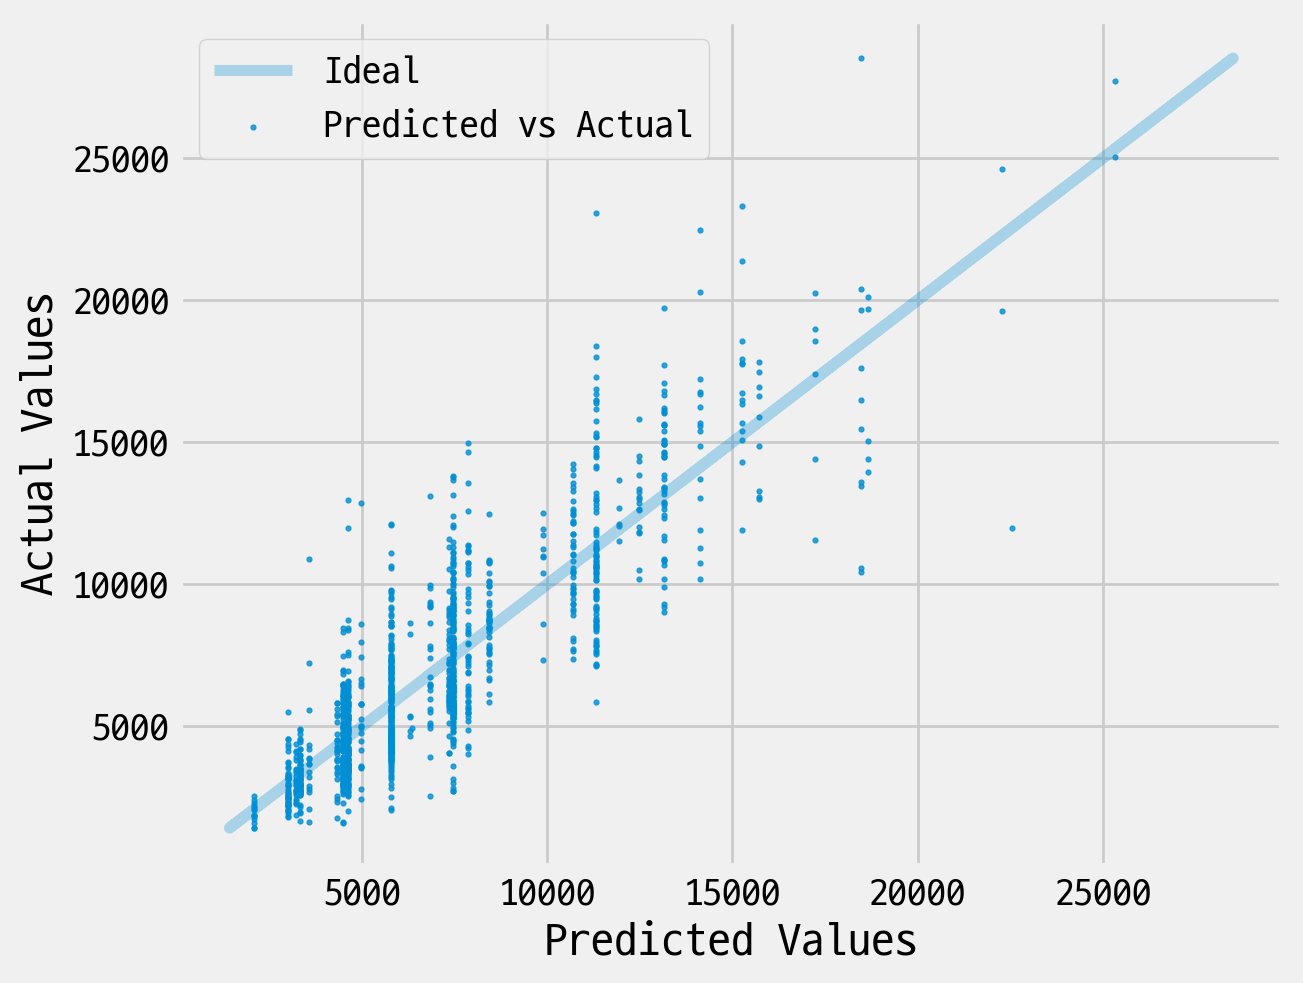

In [112]:
# 평가 지표 계산 및 출력
print("Train Mean Squared Error (MSE):", mse(y_train, y_pred_train))
print("Test Mean Squared Error (MSE):", mse(y_test, y_pred_test))
print()

print("Train Mean Absolute Percentage Error (MAPE):", mape(y_train, y_pred_train))
print("Test Mean Absolute Percentage Error (MAPE):", mape(y_test, y_pred_test))
print()


# 예측 값과 실제 값을 비교하는 산점도 및 대각선 그래프
fig, ax = plt.subplots()
ax.plot(y_test, y_test, alpha=0.3, label='Ideal')  # 대각선 그래프 (y = y)
ax.scatter(y_pred_test, y_test, s=3, alpha=0.8, label='Predicted vs Actual')  # 실제 값 대 예측 값 산점도
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.legend()

In [113]:
r2_score(y_pred_test,y_test)

0.6590632261122971

In [116]:
r2_score(y_test,y_pred_test)

0.8062734003023926

In [108]:
len(y_test), len(y_pred_test)

(1365, 1365)

In [109]:
y_test

,Deaths | Premature Death
1775,6714.055103
3351,7574.098632
4553,5646.357481
5103,8633.328322
1418,3784.795546
...,...
789,3830.174434
3715,3502.083552
6659,3481.654688
2266,5417.272148


In [102]:
y_test.values.reshape(-1)-y_pred_test

array([-849.77236237, -384.81085579, -811.28432938, ..., -801.13364765,
        184.2526126 ,  165.94828395])

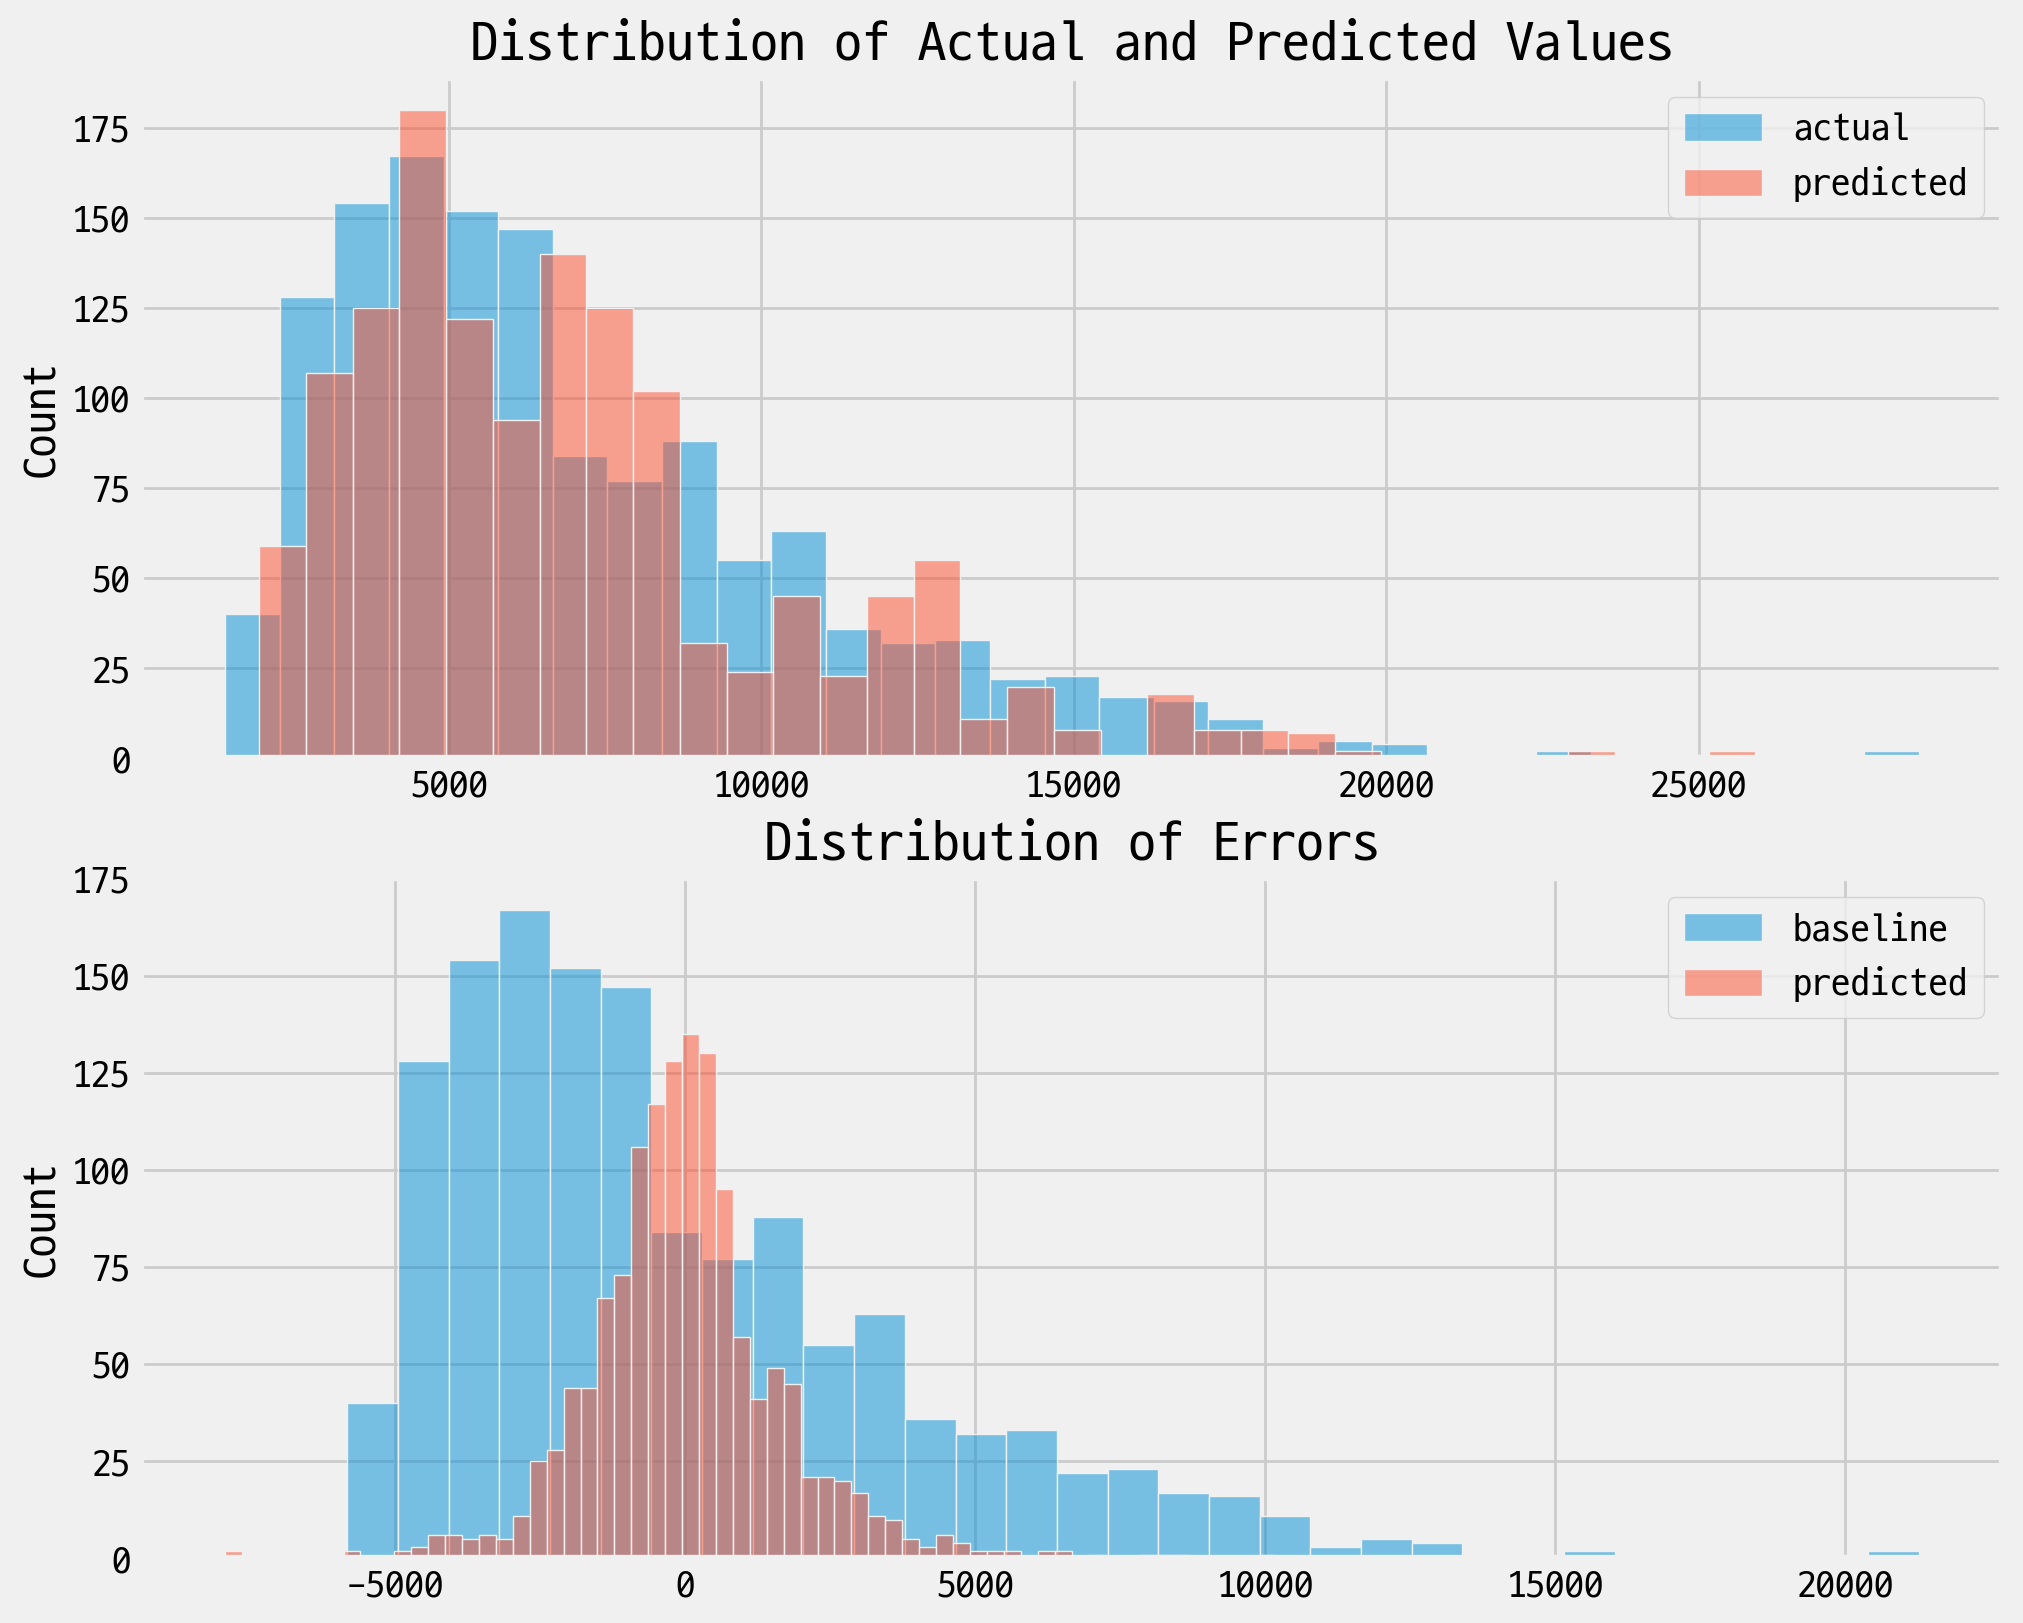

In [103]:
# 히스토그램 비교
fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # 그래프 크기 조정 (옵션)

# 첫 번째 서브플롯: 실제 값과 예측 값의 히스토그램
sns.histplot(y_test, label='actual', ax=axes[0], alpha=0.5)
sns.histplot(y_pred_test, label='predicted', ax=axes[0], alpha=0.5)
axes[0].set_title('Distribution of Actual and Predicted Values')
axes[0].legend()

# 두 번째 서브플롯: 기준선과 예측 오차의 히스토그램
sns.histplot(y_test.values.reshape(-1) - np.mean(y_train), ax=axes[1], label='baseline', alpha=0.5)
sns.histplot((y_test.values.reshape(-1) - y_pred_test),ax=axes[1], label='predicted', alpha=0.5)
axes[1].set_title('Distribution of Errors')
axes[1].legend()

In [114]:
test_cols = [
    'Deaths | Premature Death',                                  
    'Deaths | Injury Deaths',                                    
    'Cancer | All Cancer Deaths',                                
    'Cardiovascular Disease | Cardiovascular Disease Deaths',    
    'Deaths | Deaths from All Causes',                           
    'Substance Use | Drug Overdose Deaths',                      
    'Cardiovascular Disease | Heart Disease Deaths',             
    'Diabetes and Obesity | Diabetes Deaths',                    
    'Cancer | Lung Cancer Deaths',                               
    'Life Expectancy at Birth | Life Expectancy',                
    'Mental Health | Suicide',                                   
    'Deaths | Motor Vehicle Deaths',                             
    'Deaths | Gun Deaths (Firearms)',                            
    'Respiratory Infection | Pneumonia or Influenza Deaths',     
    'Substance Use | Opioid Overdose Deaths',                    
    'Cancer | Colorectal Cancer Deaths',                         
    'Crime Incidents | Homicides',                               
]

Deaths | Premature Death
Train Mean Squared Error (MSE): 3396666.2734885174
Test Mean Squared Error (MSE): 3343882.7590735517
Train Mean Absolute Percentage Error (MAPE): 0.19590669492795168
Test Mean Absolute Percentage Error (MAPE): 0.1911249493550186
0.7521302410390285
Deaths | Deaths from All Causes
Train Mean Squared Error (MSE): 3396666.2734885174
Test Mean Squared Error (MSE): 3343882.7590735517
Train Mean Absolute Percentage Error (MAPE): 0.19590669492795168
Test Mean Absolute Percentage Error (MAPE): 0.1911249493550186
0.7521302410390285
Cancer | Lung Cancer Deaths
Train Mean Squared Error (MSE): 3396666.2734885174
Test Mean Squared Error (MSE): 3343882.7590735517
Train Mean Absolute Percentage Error (MAPE): 0.19590669492795168
Test Mean Absolute Percentage Error (MAPE): 0.1911249493550186
0.7521302410390285
Deaths | Gun Deaths (Firearms)
Train Mean Squared Error (MSE): 3396666.2734885174
Test Mean Squared Error (MSE): 3343882.7590735517
Train Mean Absolute Percentage Error (M

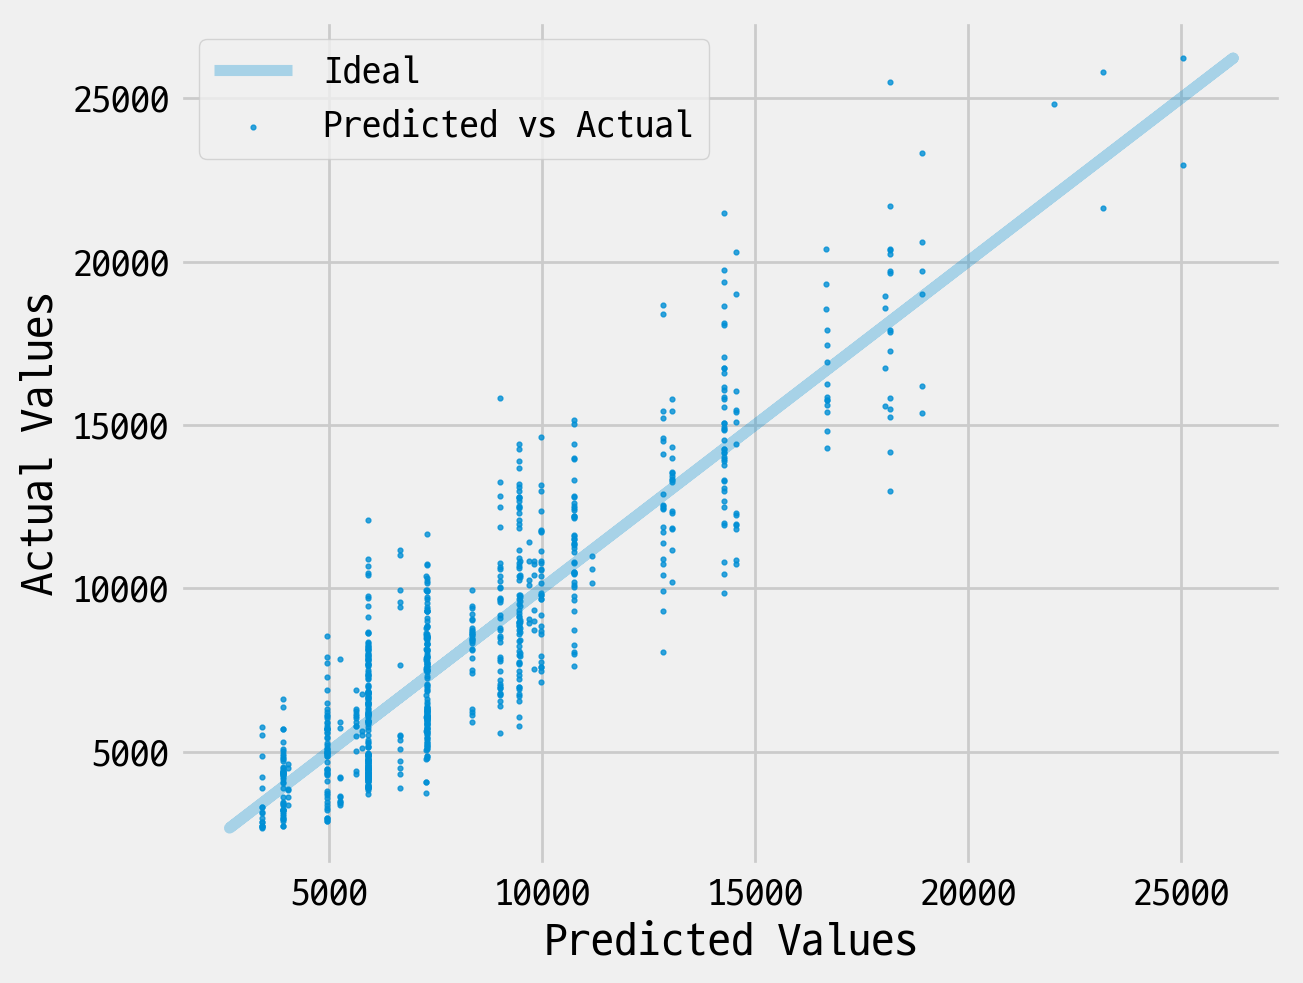

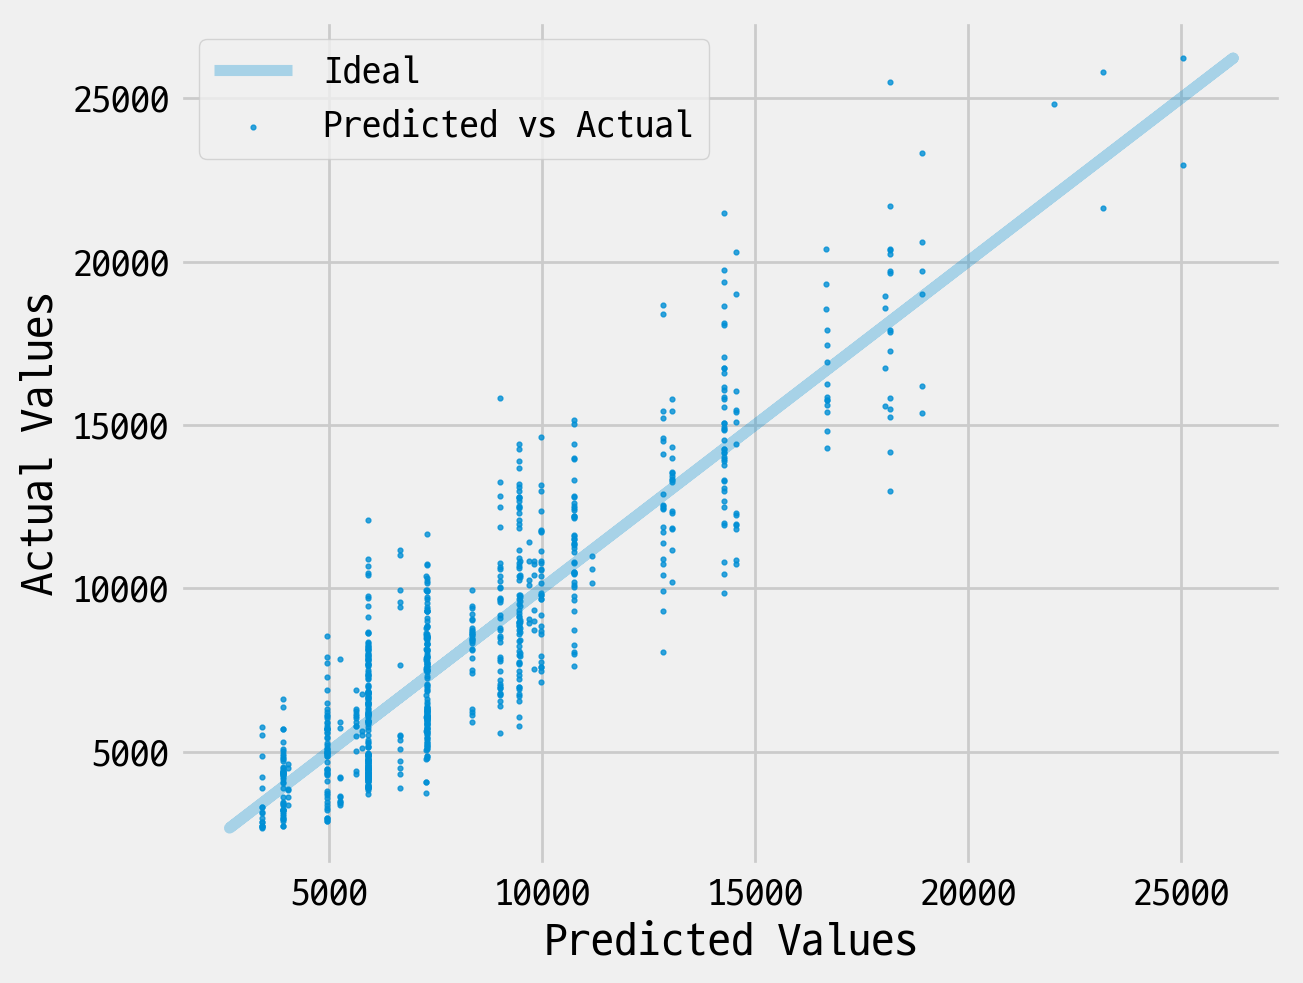

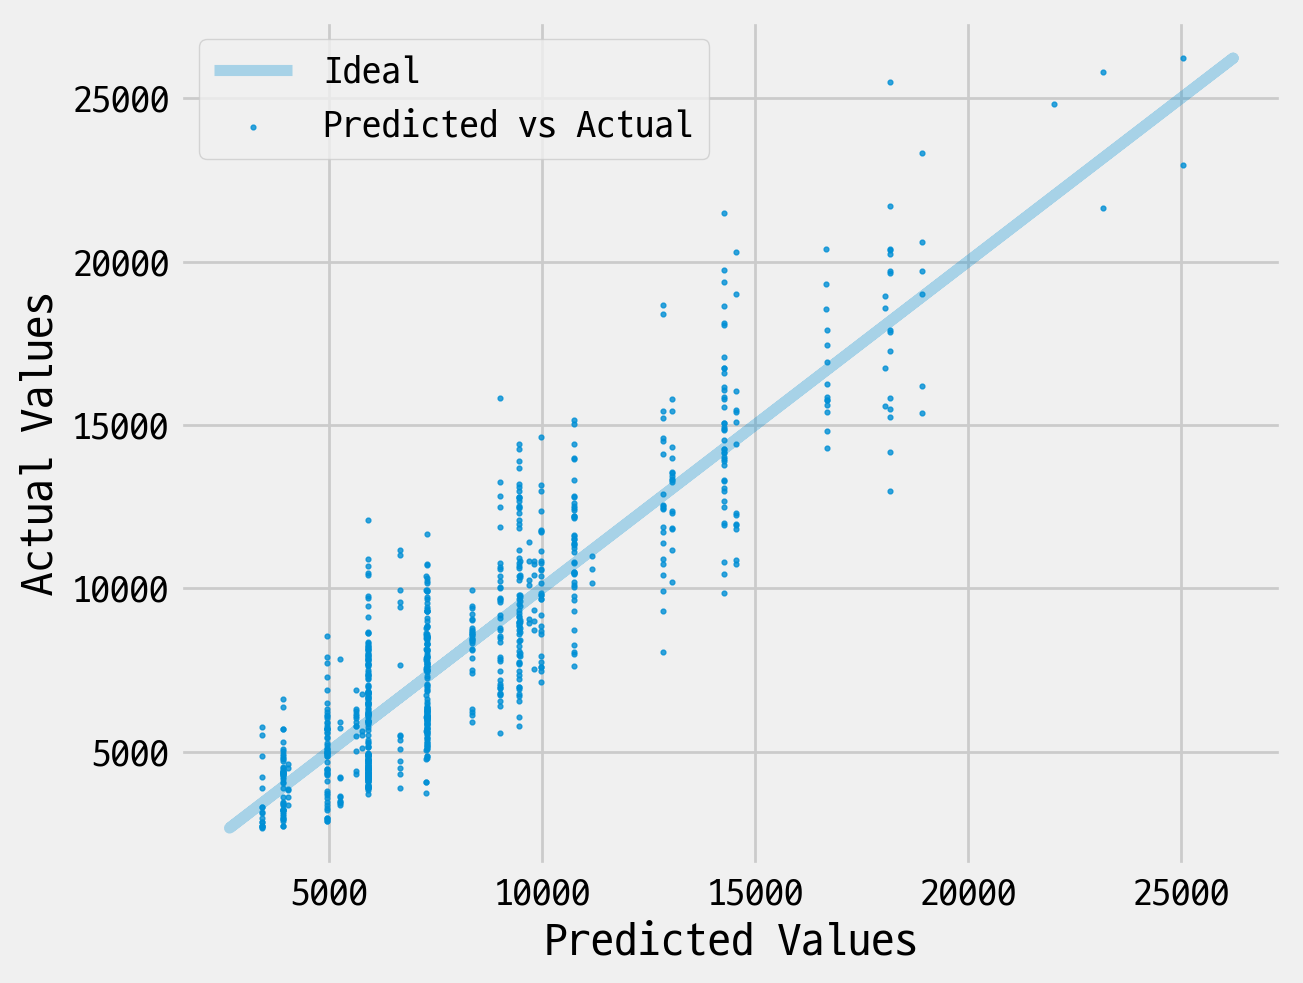

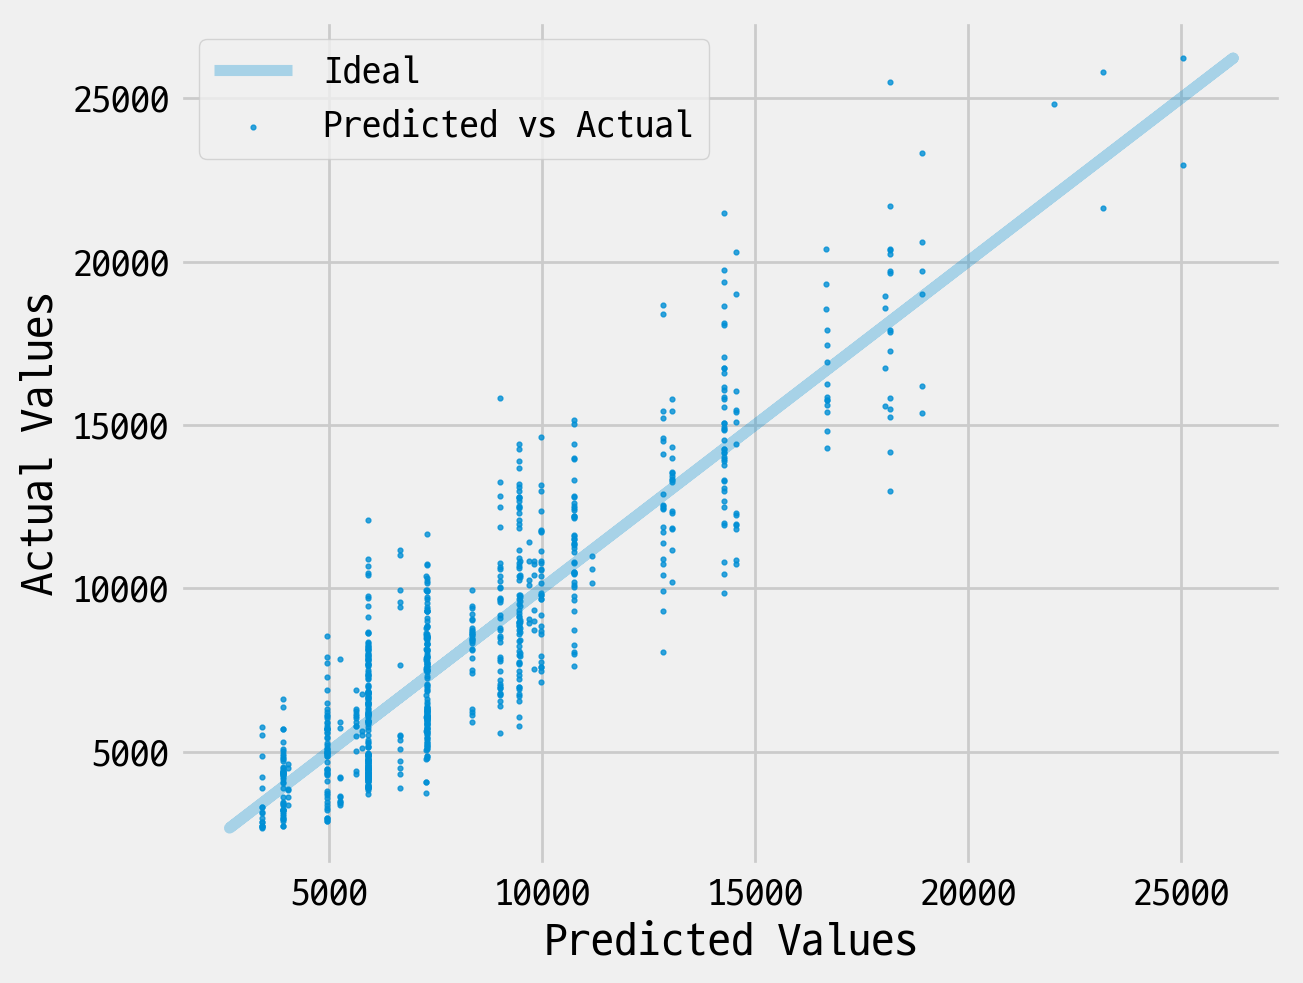

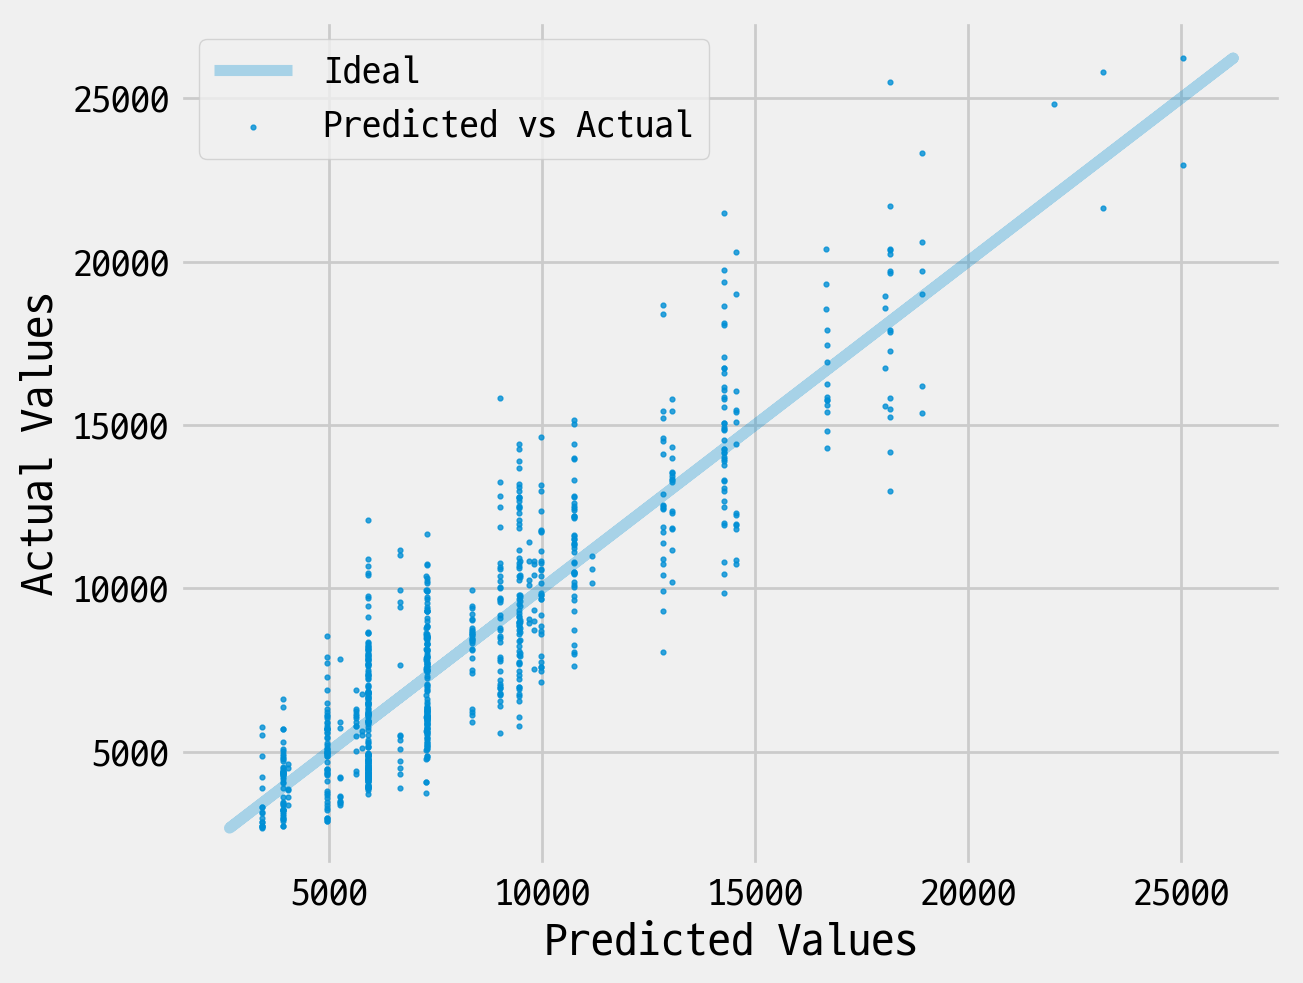

In [115]:
sample_cols = test_cols[::4]
df_data = pvtb_encoded[strata_one_hot_cols+strata_ordinal_cols+sample_cols]
df_nonan = df_data.dropna()

for test_col in sample_cols:
     
    X = df_nonan[strata_one_hot_cols+strata_ordinal_cols]
    y = df_nonan[target_col]
    
    # 학습 데이터와 테스트 데이터로 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=801)
    
    # 결정 트리 모델 생성 및 학습
    dt_model = DecisionTreeRegressor(random_state=42, max_depth=5)
    dt_model.fit(X_train, y_train)
    
    # 예측 수행
    y_pred_train = dt_model.predict(X_train)
    y_pred_test = dt_model.predict(X_test)
    
    # 평가 지표 계산 및 출력
    print(test_col)
    print("Train Mean Squared Error (MSE):", mse(y_train, y_pred_train))
    print("Test Mean Squared Error (MSE):", mse(y_test, y_pred_test))
    
    print("Train Mean Absolute Percentage Error (MAPE):", mape(y_train, y_pred_train))
    print("Test Mean Absolute Percentage Error (MAPE):", mape(y_test, y_pred_test))
    print(r2_score(y_pred_test,y_test))
    
    
    # 예측 값과 실제 값을 비교하는 산점도 및 대각선 그래프
    fig, ax = plt.subplots()
    ax.plot(y_test, y_test, alpha=0.3, label='Ideal')  # 대각선 그래프 (y = y)
    ax.scatter(y_pred_test, y_test, s=3, alpha=0.8, label='Predicted vs Actual')  # 실제 값 대 예측 값 산점도
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    ax.legend()